# Project Topic: Application of Ensemble Learning (Blending) in predicting positive moves (uptrend), a case-study on Nvidia Corporation.
### - Caleb Fowowe

#### Import Libraries

In [1]:
#Import the internal modules written for the purpose of this project
from src.utils_data_processing import LoadData, cwts, getpath
from src.utils_features_engineering import (FeaturesCreation, FeaturesTransformation, FeaturesSelection)
from src.utils_model_and_tuning import Blending, HpTuning

#Import external modules for the basemodels and blender (metamodel)
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

#Other external modules used for the Backtest
import numpy as np
import quantstats as qs
from datetime import datetime

# Creates a folder for saving of code graphics and trading strategy report.
output_path = getpath()

### Load Data, EDA, Fix Null Data, and Plots

##### Load data

In [7]:
#File names of the used data, provided as dictionary values.
data_files = {'files': ['NVDA', 'VVIX_History', 'USCPI', 'USGDP', 'FedFundRate', '2yrTreasury', '10yrTreasury']} 

time_period = ['2008', '2024'] #specifies a period range, in the case provided data is goes back than required.
company_name = data_files['files'][0] #Extract the company name or ticker into the company_name variable

ldata = LoadData(*time_period, **data_files) #instantiate the class

#Call the function to merger all the data into a single dataframe and returns the dataframe into variable 'df'
df = ldata.joinData()

#### Exploratory Data Analysis (EDA) of Original dataset

##### Cleaning and Imputation

In [8]:
df.describe()

,Open,High,Low,Close,Volume,MarketValue,DividendYield,PriceToEarnings,EPS,PriceToCash,PriceToBook,VVIX,CPI,GDP,FedFundRate,2yrTreasury,10yrTreasury
count,4184.000000,4184.000000,4184.000000,4338.000000,4.184000e+03,4.338000e+03,4338.000000,4011.000000,4338.000000,4338.000000,4338.000000,4182.000000,199.000000,66.000000,199.000000,3936.000000,3936.000000
mean,9.686341,9.866488,9.491642,9.708828,5.378152e+05,2.393138e+05,0.511072,46.733682,0.139166,26.082935,10.291561,93.378857,0.024818,0.020370,0.012487,1.404966,2.561667
std,19.972159,20.353512,19.527211,20.018970,3.248914e+05,4.952917e+05,0.738145,37.208998,0.262823,18.053104,11.703921,16.544725,0.020893,0.061028,0.015822,1.366048,0.917294
min,0.150000,0.159500,0.143700,0.147500,4.564510e+04,3.283830e+03,0.000000,7.300000,0.000000,6.960000,1.330000,59.740000,-0.021000,-0.280207,0.002500,0.109000,0.498000
25%,0.380925,0.386300,0.376500,0.381000,3.255522e+05,8.954430e+03,0.000000,19.700000,0.020000,10.810000,2.320000,82.230000,0.013150,0.011288,0.002500,0.367750,1.873750
50%,0.901450,0.911850,0.893250,0.900750,4.649226e+05,1.962008e+04,0.120000,39.600000,0.030000,20.785000,5.045000,90.095000,0.020000,0.023156,0.002500,0.841500,2.486000
75%,9.225500,9.335500,9.117125,9.231125,6.596080e+05,2.270856e+05,0.560000,62.800000,0.150000,35.567500,15.525000,102.047500,0.032100,0.034362,0.018750,2.130250,3.269000
max,139.800000,140.760000,132.420000,135.580000,3.692926e+06,3.335269e+06,2.640000,246.900000,1.710000,106.290000,77.730000,207.590000,0.090600,0.348397,0.055000,5.220000,4.983000


In [9]:
#Check for missing points and values within the combined dataset
ldata.checkNullData(df)#within the ldata object, call the checkNullData method, with the df as input parameter

,Open,High,Low,Close,Volume,MarketValue,DividendYield,PriceToEarnings,EPS,PriceToCash,PriceToBook,VVIX,CPI,GDP,FedFundRate,2yrTreasury,10yrTreasury
Dates,,,,,,,,,,,,,,,,,
2008-01-01,NaN,NaN,NaN,0.8505,NaN,18900.51,0.0,29.3,0.03,18.76,7.24,NaN,NaN,NaN,NaN,3.057,4.032
2008-01-02,0.8530,0.8562,0.8140,0.8252,483981.1,18339.39,0.0,28.4,0.03,18.21,7.02,80.58,NaN,NaN,NaN,2.079,3.598
2008-01-03,0.8300,0.8465,0.8157,0.8187,475385.9,18194.94,0.0,28.2,0.03,18.06,6.97,79.33,NaN,NaN,NaN,NaN,NaN
2008-01-04,0.7942,0.7982,0.7450,0.7500,736136.8,16667.13,0.0,25.8,0.03,16.55,6.38,81.46,NaN,NaN,NaN,1.802,3.566
2008-01-07,0.7550,0.7612,0.6587,0.6725,1006894.0,14944.85,0.0,23.1,0.03,14.84,5.72,79.51,NaN,NaN,NaN,2.656,4.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09,105.6400,106.6000,103.4300,104.7500,290844.2,2576851.00,0.0,61.3,1.71,82.12,60.05,114.63,NaN,NaN,NaN,NaN,NaN
2024-08-12,106.3200,111.0700,106.2600,109.0200,325559.9,2681893.00,0.0,63.8,1.71,85.47,62.50,121.94,NaN,NaN,NaN,NaN,NaN
2024-08-13,112.4400,116.2300,111.5800,116.1400,312646.7,2857045.00,0.0,68.0,1.71,91.05,66.58,113.89,NaN,NaN,NaN,3.940,3.850


In [12]:
#Intial step of fixing missing data, backfill the quarterly, and monthly macrodata,to 
df = ldata.fixNullData(df, method='bfill')

In [13]:
#Post-backfilling check for null data after fixing null data
ldata.checkNullData(df)

,Open,High,Low,Close,Volume,MarketValue,DividendYield,PriceToEarnings,EPS,PriceToCash,PriceToBook,VVIX,CPI,GDP,FedFundRate,2yrTreasury,10yrTreasury
Dates,,,,,,,,,,,,,,,,,
2024-07-01,123.47,124.84,118.8300,124.30,284885.6,3057781.0,0.0,72.8,1.71,97.45,71.26,76.05,0.0289,NaN,0.055,4.433,4.115
2024-07-02,121.13,123.41,121.0300,122.67,218374.0,3017683.0,0.0,71.8,1.71,96.17,70.33,77.06,0.0289,NaN,0.055,4.433,4.115
2024-07-03,121.66,128.28,121.3600,128.28,215748.9,3155689.0,0.0,75.1,1.71,100.57,73.54,78.07,0.0289,NaN,0.055,4.516,4.092
2024-07-04,127.38,128.85,125.6800,128.28,214176.7,3155689.0,0.0,75.1,1.71,100.57,73.54,78.80,0.0289,NaN,0.055,4.824,4.457
2024-07-05,127.38,128.85,125.6800,125.83,214176.7,3095419.0,0.0,73.7,1.71,98.65,72.14,78.80,0.0289,NaN,0.055,4.824,4.457
2024-07-08,127.49,130.77,127.0400,128.20,237677.3,3153721.0,0.0,75.1,1.71,100.51,73.50,78.59,0.0289,NaN,0.055,3.994,3.901
2024-07-09,130.35,133.82,128.6500,131.38,287020.8,3231949.0,0.0,76.9,1.71,103.00,75.32,78.58,0.0289,NaN,0.055,4.447,4.226
2024-07-10,134.03,135.10,132.4200,134.91,248978.6,3318787.0,0.0,79.0,1.71,105.77,77.35,83.41,0.0289,NaN,0.055,4.447,4.226
2024-07-11,135.75,136.15,127.0500,127.40,374782.8,3134041.0,0.0,74.6,1.71,99.88,73.04,84.47,0.0289,NaN,0.055,4.447,4.226


In [14]:
#fix future data that are not available yet, can drop rows to choose, knn_impute method was used here.
df = ldata.fixNullData(df, method='knnimpute')

In [15]:
df.describe()

,Open,High,Low,Close,Volume,MarketValue,DividendYield,PriceToEarnings,EPS,PriceToCash,PriceToBook,VVIX,CPI,GDP,FedFundRate,2yrTreasury,10yrTreasury
count,4338.000000,4338.000000,4338.000000,4338.000000,4.338000e+03,4.338000e+03,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,9.707814,9.888444,9.512599,9.708828,5.356071e+05,2.393138e+05,0.511072,45.291379,0.139166,26.082935,10.291561,93.325260,0.024835,0.020441,0.012600,1.422183,2.571488
std,20.038928,20.420068,19.587281,20.018970,3.245462e+05,4.952917e+05,0.738145,36.133681,0.262823,18.053104,11.703921,16.503103,0.020827,0.060461,0.015914,1.383413,0.925052
min,0.150000,0.159500,0.143700,0.147500,4.564510e+04,3.283830e+03,0.000000,7.300000,0.000000,6.960000,1.330000,59.740000,-0.021000,-0.280207,0.002500,0.109000,0.498000
25%,0.381125,0.386775,0.377000,0.381000,3.239548e+05,8.954430e+03,0.000000,20.100000,0.020000,10.810000,2.320000,82.200000,0.013100,0.010749,0.002500,0.367000,1.875000
50%,0.901450,0.911850,0.893250,0.900750,4.630821e+05,1.962008e+04,0.120000,33.600000,0.030000,20.785000,5.045000,90.075000,0.020000,0.022928,0.002500,0.850000,2.493500
75%,9.226500,9.408500,9.122375,9.231125,6.590332e+05,2.270856e+05,0.560000,58.975000,0.150000,35.567500,15.525000,102.010000,0.032400,0.034493,0.020000,2.174250,3.303000
max,139.800000,140.760000,132.420000,135.580000,3.692926e+06,3.335269e+06,2.640000,246.900000,1.710000,106.290000,77.730000,207.590000,0.090600,0.348397,0.055000,5.220000,4.983000


In [16]:
# preview the latest five (5) values of the cleaned up data
df.tail()

,Open,High,Low,Close,Volume,MarketValue,DividendYield,PriceToEarnings,EPS,PriceToCash,PriceToBook,VVIX,CPI,GDP,FedFundRate,2yrTreasury,10yrTreasury
Dates,,,,,,,,,,,,,,,,,
2024-08-09,105.64,106.60,103.43,104.75,290844.2,2576851.0,0.0,61.3,1.71,82.12,60.05,114.63,0.03042,0.016531,0.055,3.940,3.850
2024-08-12,106.32,111.07,106.26,109.02,325559.9,2681893.0,0.0,63.8,1.71,85.47,62.50,121.94,0.02966,0.016531,0.055,3.940,3.850
2024-08-13,112.44,116.23,111.58,116.14,312646.7,2857045.0,0.0,68.0,1.71,91.05,66.58,113.89,0.02906,0.016531,0.055,3.940,3.850
2024-08-14,118.53,118.60,114.07,118.08,339246.4,2904769.0,0.0,69.1,1.71,92.57,67.70,107.81,0.02922,0.016531,0.055,3.964,3.833
2024-08-15,118.76,123.24,117.47,122.86,318086.7,3022357.0,0.0,71.9,1.71,96.32,70.44,105.42,0.02938,0.016531,0.055,4.097,3.915


In [21]:
# Plot candlestick of the historical stock data
# stock_split = {'event_dates': ['2024-06-10', '2007-09-11', '2006-04-07', '2001-09-12', '2000-06-27'], 'event_title': 'stock-split'}
stock_split = {'event_dates': ['2024-06-10'], 'event_title': 'stock-split'}
ldata.plotCandleStick(df, events=stock_split)

In [22]:
# plot individual (ohlcv)
ldata.plotPrices(df)

In [23]:
df

,Open,High,Low,Close,Volume,MarketValue,DividendYield,PriceToEarnings,EPS,PriceToCash,PriceToBook,VVIX,CPI,GDP,FedFundRate,2yrTreasury,10yrTreasury
Dates,,,,,,,,,,,,,,,,,
2008-01-01,0.8530,0.8562,0.8140,0.8505,483981.1,18900.51,0.0,29.3,0.03,18.76,7.24,80.58,0.04280,-0.016962,0.030,3.057,4.032
2008-01-02,0.8530,0.8562,0.8140,0.8252,483981.1,18339.39,0.0,28.4,0.03,18.21,7.02,80.58,0.04280,-0.016962,0.030,2.079,3.598
2008-01-03,0.8300,0.8465,0.8157,0.8187,475385.9,18194.94,0.0,28.2,0.03,18.06,6.97,79.33,0.04280,-0.016962,0.030,1.802,3.566
2008-01-04,0.7942,0.7982,0.7450,0.7500,736136.8,16667.13,0.0,25.8,0.03,16.55,6.38,81.46,0.04280,-0.016962,0.030,1.802,3.566
2008-01-07,0.7550,0.7612,0.6587,0.6725,1006894.0,14944.85,0.0,23.1,0.03,14.84,5.72,79.51,0.04280,-0.016962,0.030,2.656,4.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09,105.6400,106.6000,103.4300,104.7500,290844.2,2576851.00,0.0,61.3,1.71,82.12,60.05,114.63,0.03042,0.016531,0.055,3.940,3.850
2024-08-12,106.3200,111.0700,106.2600,109.0200,325559.9,2681893.00,0.0,63.8,1.71,85.47,62.50,121.94,0.02966,0.016531,0.055,3.940,3.850
2024-08-13,112.4400,116.2300,111.5800,116.1400,312646.7,2857045.00,0.0,68.0,1.71,91.05,66.58,113.89,0.02906,0.016531,0.055,3.940,3.850


## Feature Engineering

##### FeaturesEngineering Class with the entire FeaturesCreation, FeaturesTransformation, and FeaturesSelections sub-classes

#### Feature Creation/Extraction

##### Define the parameters to be used in the target variable (y)/ Label

In [24]:
# The target is a trend and volatility play which creates a signal when the return over a short period of time (5days), crosses over the return trend over a relative medium period (10days). However, there is an outperformance threshold (hurdle) over which the 5-day return must outperform the medium_period return before it is charactersized as a condtion. The other condition is a volatility play where the standard deviation of the short period return is less than the upper boundary standard deviation of the medium period return. The upper boundary of the medium period returns standard deviation is characterized as 2-standard deviations from the mean

# Target parameters
short_prd= 5 
medium_prd = 10
upper_std=2 
lower_std = 1 
hurdle = 0.005

##### Generate Features - all features (pandas-ta library)

In [25]:
# Instantiate the features creation subclass with the dataframe containing the cleaned data, and the testsize as input parameters. The testsize is opional and has a default value of 20%.
# The testsize is provided during the Features engineering process because it will be used during features selection step.

feat_df = FeaturesCreation(df, short_prd, medium_prd, upper_std, lower_std, hurdle) #Instantiate the FeaturesCreation subclass providing the dataframe and the target parametres as inputs
new_ft = feat_df.create_all_features(fundamental_features=True, macro_features=True) # If the Fundamental and Macro ratios are provided, genrates a feature set of:
#1. Company fundamentals-related Features (Requires specific column label)
#2. Macro-economic related features (Requires specific column label)
#3. Technical Indicator features (based on pandas ta-library) (Requires specific column label 'Open', 'High', 'Low', 'Close', 'Volume')

# The ohlcv columns are dropped after using them in the generation of the technical indicators. Below is a preview of the first five row of the 320features including both, macroeconomic, fundamental and technical indicators.
new_ft.head()

 August 18, 2024 - 16:25:25 -----  Price-to-Earnings-to-Dividend Ratio (PED)Ratio feature successfully calculated 
 August 18, 2024 - 16:25:25 -----  Price to Earnings and Price to Book Combined (PEPB)_Ratio feature successfully calculated 
 August 18, 2024 - 16:25:25 -----  Price to Cash & Price to Earnings Combined (PCFPER) feature successfully calculated 
 August 18, 2024 - 16:25:25 -----  combined valuation metric (cvm)_feature successfully calculated 
 August 18, 2024 - 16:25:25 -----  Yield Spread feature successfully calculated 
 August 18, 2024 - 16:25:25 -----  CPI/GDP Ratio feature successfully calculated 
 August 18, 2024 - 16:25:25 -----  CPI vs Yield Correlation feature successfully calculated 
 August 18, 2024 - 16:25:25 -----  Real Interest Rates feature successfully calculated 


,MarketValue,DividendYield,PriceToEarnings,EPS,PriceToCash,PriceToBook,VVIX,CPI,GDP,FedFundRate,...,VWMA_10,TSV_18_10,TSVs_18_10,TSVr_18_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,predict
Dates,,,,,,,,,,,,,,,,,,,,,
2008-05-20,12914.2,0.0,16.7,0.03,45.15,5.23,79.8,0.0418,0.024031,0.02,...,0.569163,107247.36731,106490.922927,1.007103,2.3272,-44.010417,0.577396,0.600035,1.325277,1
2008-05-21,12808.8,0.0,16.6,0.03,44.78,5.19,80.12,0.0418,0.024031,0.02,...,0.57114,99365.78031,108105.843428,0.919153,2.3364,-51.627907,0.579047,0.592737,1.137867,1
2008-05-22,13119.45,0.0,17.0,0.03,45.87,5.32,83.62,0.0418,0.024031,0.02,...,0.575356,113894.69491,110168.544884,1.033822,2.3546,-38.604651,0.582753,0.589003,1.339525,1
2008-05-23,12819.89,0.0,16.6,0.03,44.82,5.2,79.63,0.0418,0.024031,0.02,...,0.578207,97149.67623,107847.812006,0.900803,2.3196,-51.162791,0.583231,0.583348,0.988263,1
2008-05-26,12819.89,0.0,16.6,0.03,44.82,5.2,79.35,0.0418,0.024031,0.02,...,0.581535,87855.32703,107355.440848,0.818359,2.3078,-51.162791,0.583445,0.581539,0.937934,0


In [26]:
new_ft.shape

(4238, 339)

#### Feature Transformation & Selection

##### Transform day feature column

In [27]:
# Prior to starting to features selection process, the days features which consist of trading days (Monday - Friday), is transformed, to two features.
feat_transform = FeaturesTransformation(new_ft) #Instantiate the FeaturesTransformation subclass providing the dataset with the generated features as input
new_ft2 = feat_transform.transformDaysColumn() # Invoke the transformDaysColumn method which has the defined DaysTransformer subclass to transform the 'days' column. The column named 'days' must be in the input dataset for this method to execute. The whole feature set with the transformed 'days' column is stored in the 'new_ft2' variable.

###### To optimize the dataframe performance, the all features outside the target column are convereted to 'float64', with the target variable column converted to 'int16' datatype

In [28]:
new_ft2 = new_ft2.astype('float64')
new_ft2['predict'] = new_ft2['predict'].values.astype('int16')

In [29]:
new_ft2

,MarketValue,DividendYield,PriceToEarnings,EPS,PriceToCash,PriceToBook,VVIX,CPI,GDP,FedFundRate,...,TSVs_18_10,TSVr_18_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,predict,dsin,dcos
Dates,,,,,,,,,,,,,,,,,,,,,
2008-05-20,12914.20,0.0,16.7,0.03,45.15,5.23,79.80,0.04180,0.024031,0.020,...,1.064909e+05,1.007103,2.3272,-44.010417,0.577396,0.600035,1.325277,1,0.974928,-0.222521
2008-05-21,12808.80,0.0,16.6,0.03,44.78,5.19,80.12,0.04180,0.024031,0.020,...,1.081058e+05,0.919153,2.3364,-51.627907,0.579047,0.592737,1.137867,1,0.433884,-0.900969
2008-05-22,13119.45,0.0,17.0,0.03,45.87,5.32,83.62,0.04180,0.024031,0.020,...,1.101685e+05,1.033822,2.3546,-38.604651,0.582753,0.589003,1.339525,1,-0.433884,-0.900969
2008-05-23,12819.89,0.0,16.6,0.03,44.82,5.20,79.63,0.04180,0.024031,0.020,...,1.078478e+05,0.900803,2.3196,-51.162791,0.583231,0.583348,0.988263,1,-0.974928,-0.222521
2008-05-26,12819.89,0.0,16.6,0.03,44.82,5.20,79.35,0.04180,0.024031,0.020,...,1.073554e+05,0.818359,2.3078,-51.162791,0.583445,0.581539,0.937934,0,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09,2576851.00,0.0,61.3,1.71,82.12,60.05,114.63,0.03042,0.016531,0.055,...,-9.769845e+06,1.035167,419.5300,-58.647059,104.713818,102.674209,-1.287469,0,-0.974928,-0.222521
2024-08-12,2681893.00,0.0,63.8,1.71,85.47,62.50,121.94,0.02966,0.016531,0.055,...,-9.657405e+06,0.565189,435.3700,-37.801154,105.223818,104.695262,-0.818843,0,0.781831,0.623490
2024-08-13,2857045.00,0.0,68.0,1.71,91.05,66.58,113.89,0.02906,0.016531,0.055,...,-9.039212e+06,0.467657,460.0900,-13.640991,107.075091,109.908851,-0.110468,0,0.974928,-0.222521


#### Feature Selection

###### Feature selection - Wrapper Method: Boruta and Recursive Forward Elimination (RFE)

In [30]:
feat_select = FeaturesSelection(new_ft2, testsize = 0.20) #instantiate the FeaturesSelection subclass, providing dataframe from above, with the days column transformed as required input parameters, and the testsize as an optional input parameter as well. Default testsize is 0.20.
feat1 = feat_select.wrapper_boruta(max_iter=200) # Invoke the wrapper_boruta method within the FeaturesSelection subclass.

#The wrapper_boruta method

Pre-Boruta selection metrics: Accuracy Score:  91.63%, f1_score: 91.65% 


Using the (110)BorutaSelected Features, metrics: Accuracy Score: 95.75%, f1_score: 95.76% 


 Using Recursive Forward Elimination (RFE) approach to validate the (110)features selected by Boruta approach,(88)features which are the intersect features for both Boruta and RFE, the evaluation metrics using the (88)features are: Accuracy Score:  95.52%, f1_score: 95.52% 



##### Feature selection - Filtering Method: Addressing Multicollinearity among features

###### using the same Feature Selection class, specify the correlation coefficient Threshold of choice. (The projected tested correlation in the 0.60 - 0.90) ranges.

In [31]:
# Call the filter_correlation method, within the class providing it with the desired correlation threshold.
# The multicollinearity steps follows the Boruta and RFE intersection steps. Hence, there is no need to specify the dataframe, the code has designed such that it already takes as input the dataframe which contains the features output of Boruta and RFE intersection. 
# However, for testing purposes, there's an optionality to provide the function with both correlation coefficient and dataframe, and it will filter for multicollinearitu among features.
filtered_feature = feat_select.filter_correlation(corr_coeff=0.70)  


 Solving for multicollinearity of features, and applying correlation coefficient of 0.7, the (88)features selected which are the intersected features of Boruta and Recursive ForwardElimination (RFE) were filtered to 24 features 


 After addressing the multicollinearity among features, applying RandomForestClassifier to predictthe (24)Filtered Features gives the following values for tracked metrics: Accuracy Score: 92.81%, f1_score: 92.81% 

╒═════╤═══════════════════════════╕
│   # │ Filtered Features Names   │
╞═════╪═══════════════════════════╡
│   0 │ FISHERT_9_1               │
│   1 │ EXHC_UPa                  │
│   2 │ PCTRET_1                  │
│   3 │ TSVs_18_10                │
│   4 │ PVO_12_26_9               │
│   5 │ EFI_13                    │
│   6 │ PVIe_255                  │
│   7 │ PPO_12_26_9               │
│   8 │ TRIX_30_9                 │
│   9 │ PVOh_12_26_9              │
│  10 │ BBB_5_2.0                 │
│  11 │ CCI_14_0.015              │
│  12 │ RVI_1

In [32]:
data3 = new_ft2[filtered_feature]
data3['predict'] = new_ft2['predict'].values.astype('int')

data3.head()

,FISHERT_9_1,EXHC_UPa,PCTRET_1,TSVs_18_10,PVO_12_26_9,EFI_13,PVIe_255,PPO_12_26_9,TRIX_30_9,PVOh_12_26_9,...,CHOP_14_1_100.0,SMCbi_14_50_20_5,SKEW_30,EXHC_DNa,ER_10,QS_10,RealRates,KURT_30,CFO_9,predict
Dates,,,,,,,,,,,,,,,,,,,,,
2008-05-20,1.421232,5.0,-0.025941,106490.922927,6.493097,4481.008283,6.493097,6.900575,-0.102895,-1.731517,...,46.633920,-0.0363,0.193111,0.0,0.118537,0.00019,3.586293,-0.921150,-3.979572,1
2008-05-21,1.256064,0.0,-0.008247,108105.843428,6.521743,3109.392243,6.521743,6.384704,-0.077074,-1.362297,...,49.732628,-0.0567,0.055751,1.0,0.179521,0.00101,3.618929,-1.017228,-4.256661,1
2008-05-22,1.071798,0.0,0.024255,110168.544884,3.446177,4051.846551,3.446177,5.905104,-0.051582,-3.550290,...,49.187956,-0.0118,-0.052951,2.0,0.260896,0.00216,3.717796,-1.105038,-2.614269,1
2008-05-23,0.874516,0.0,-0.022835,107847.812006,1.851471,1924.987736,1.851471,5.478238,-0.027352,-4.115997,...,50.185305,-0.0368,-0.173338,3.0,0.089561,-0.00039,3.659244,-1.037619,-3.569230,1
2008-05-26,0.595625,0.0,0.000000,107355.440848,0.822102,1649.989488,0.822102,5.162219,-0.004448,-4.116293,...,49.379962,-0.0283,-0.215831,4.0,0.209047,0.00184,3.659244,-1.054467,-1.093897,0


### Ensemble Model - Blending Ensemble

##### Initial parameterization of basemodels and metamodel

In [33]:
cls_weight = cwts(data3)

lr_params = {'random_state': 1, 'class_weight': cls_weight}
lr = LogisticRegression(**lr_params)

dt_params = {'class_weight': cls_weight, 'random_state': 1}
dt = DecisionTreeClassifier(**dt_params)

knn_params = {'algorithm': 'auto', 'n_jobs': -1}
knn = KNeighborsClassifier(**knn_params)

bayes_params = {}
bayes = GaussianNB()
bayes.set_params(**bayes_params)

svc_params = {'class_weight': cls_weight,'random_state': 1, 'probability': True}
svc = SVC(**svc_params)

basemodels = {'lr': lr, 'dte': dt, 'knn': knn, 'bayes': bayes, 'svc': svc}

xgb_params = {'n_jobs': -1, 'class_weight': cls_weight, 'random_state': 1, 'verbose': 1}
xgb = XGBClassifier(**xgb_params)

blender = xgb

##### Initial run of the blending model

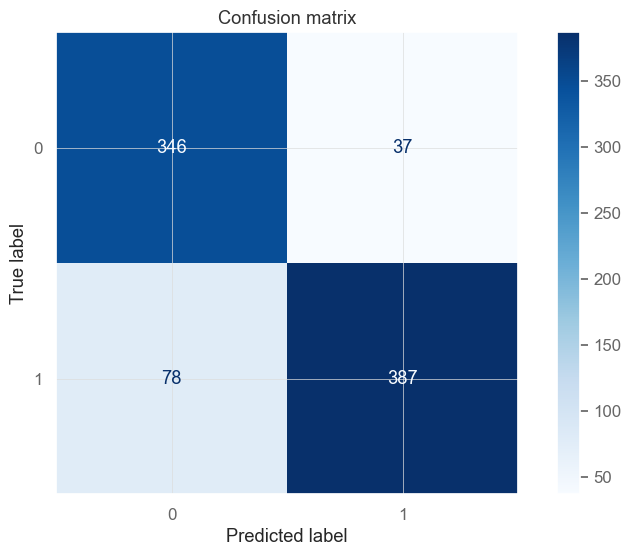

AUC-ROC curve 



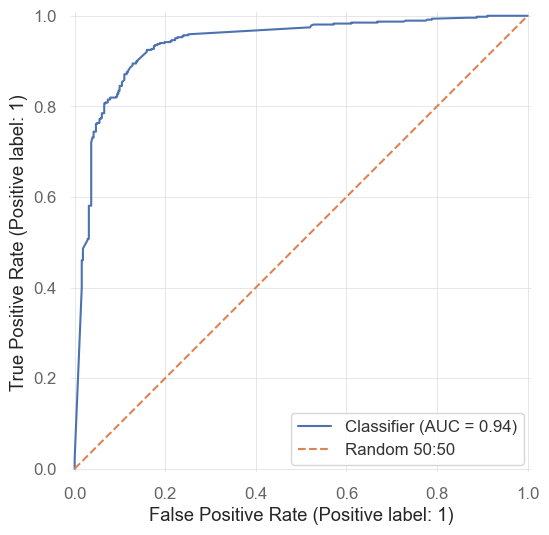

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       383
           1       0.91      0.83      0.87       465

    accuracy                           0.86       848
   macro avg       0.86      0.87      0.86       848
weighted avg       0.87      0.86      0.86       848

Accuracy Score:  86.4%, f1score: 86.5%


In [34]:
#Separate final X and y - Features and target
X_final = data3.iloc[:,:-1].values
y_final = data3.iloc[:,-1].values

Blnd = Blending(X_final, y_final, basemodels, blender, valsize=0.20)
acc, f1score, ypred, yprob, yfull = Blnd.runBlendingEnsemble()

print(f"Accuracy Score: {acc: .1%}, f1score: {f1score:.1%}")

#### Hyperparameter Tuning

In [35]:
#Instantiate tuning
tune_model = HpTuning(X_final, y_final, n_trials=40)
tuned_lr, tuned_dt, tuned_svc, tuned_knn, tuned_bayes, tuned_xgb = tune_model.optimize_lr(), tune_model.optimize_dt(), tune_model.optimize_svc(), tune_model.optimize_knn(), tune_model.optimize_bayes(), tune_model.optimize_xgb()

print("optimal_lr:", tuned_lr.values, "\t","optimal_dt:", tuned_dt.values, "\t", "optimal_svc:", tuned_svc.values, "\t", "optimal_knn:", tuned_knn.values, "\t", "optimal_bayes:", tuned_bayes.values, "\t", "optimal_xgb:", tuned_xgb.values)

optimal_lr: [0.9060713782012477, 0.9061393152302243] 	 optimal_dt: [0.8749353546116524, 0.8754427390791029] 	 optimal_svc: [0.9010835323266325, 0.9011216056670601] 	 optimal_knn: [0.894525371990318, 0.8943329397874853] 	 optimal_bayes: [0.8161262646210841, 0.8161157024793388] 	 optimal_xgb: [0.922579812462881, 0.9223730814639904]


#### Run Ensemble Model with tuned parameters

##### Update the initial parameters dictionary with the hyperparameter tuning parameter values

In [36]:
lr_params.update(tuned_lr.params)
lr = LogisticRegression(**lr_params)

dt_params.update(tuned_dt.params)
dt = DecisionTreeClassifier(**dt_params)

knn_params.update(tuned_knn.params)
knn = KNeighborsClassifier(**knn_params)

bayes_params = {}
bayes = GaussianNB()
bayes.set_params(**bayes_params)

svc_params.update(tuned_svc.params)
svc = SVC(**svc_params)

basemod_upd = {'lre': lr, 'dte': dt, 'knn': knn, 'bayes': bayes, 'svc': svc}

xgb_params.update(tuned_xgb.params)
xgb = XGBClassifier(**xgb_params)

blender_upd = xgb

##### TunedModels Output

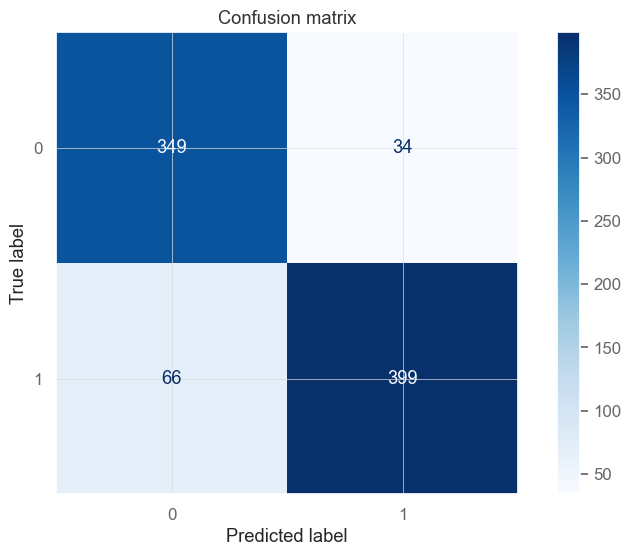

AUC-ROC curve 



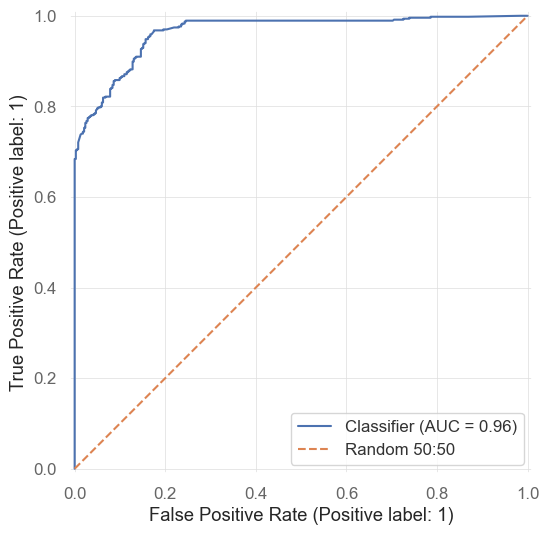

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       383
           1       0.92      0.86      0.89       465

    accuracy                           0.88       848
   macro avg       0.88      0.88      0.88       848
weighted avg       0.89      0.88      0.88       848

Accuracy Score:  88.2%, f1score: 88.2%


In [37]:
Blnd = Blending(X_final, y_final, basemod_upd, blender_upd, valsize=0.20)
acc_tuned, f1score_tuned, ypred_tuned, yprob_tuned, yfull_tuned = Blnd.runBlendingEnsemble()

print(f"Accuracy Score: {acc_tuned: .1%}, f1score: {f1score_tuned:.1%}")

### Backtest/Strategy Evaluation

##### Trading Strategy - full period backtest

In [38]:
return_period = 1

In [39]:
# Extract Close prices over the range of dates of the full model
backtest_data = df[['Close', 'Open']][-len(yfull_tuned):]
backtest_data['Signal'] = yfull_tuned

backtest_data

,Close,Open,Signal
Dates,,,
2008-05-20,0.5820,0.5812,1
2008-05-21,0.5772,0.5835,1
2008-05-22,0.5912,0.5855,1
2008-05-23,0.5777,0.5902,1
2008-05-26,0.5777,0.5787,0
...,...,...,...
2024-08-09,104.7500,105.6400,0
2024-08-12,109.0200,106.3200,0
2024-08-13,116.1400,112.4400,1


In [40]:
#Entry logic
backtest_data['Entry'] = np.where(backtest_data['Signal']==1, backtest_data['Close'], 0) #when the strategy signal is 1, we enter into a trade, and buy at the end of day's close.

#Exit Logic
backtest_data['Exit'] = np.where((backtest_data['Entry'] != 0) & (backtest_data['Open'].shift(-return_period) <= backtest_data['Close']),
                         backtest_data['Open'].shift(-return_period), 0) #
backtest_data['Exit'] = np.where((backtest_data['Entry'] != 0) & (backtest_data['Open'].shift(-return_period) > backtest_data['Close']),
                         backtest_data['Close'].shift(-return_period), backtest_data['Exit'])

# Calculate MTM
backtest_data['P&L'] = backtest_data['Exit'] - backtest_data['Entry']

# Generate Equity Curve
backtest_data['Equity'] = backtest_data['P&L'].cumsum() + backtest_data['Close'][0]

# Calculate Benchmark Return
backtest_data['Benchmark'] = np.log(backtest_data['Close']).diff().fillna(0)

# Calculate Strategy Return
backtest_data['Strategy'] = (backtest_data['Equity']/backtest_data['Equity'].shift(return_period) - 1).fillna(0)
backtest_data = backtest_data.iloc[:-1]

##### Calculate the Sharpe Ratio

In [41]:
bts = backtest_data[['Benchmark','Strategy']]
qs.stats.sharpe(bts)

Benchmark    0.657958
Strategy     0.852877
dtype: float64

In [42]:
# generate report and save in the output folder
date_time = datetime.now().strftime('%Y-%m-%d, %H%M%S')
qs.reports.html(bts['Strategy'], bts['Benchmark'],  title=f'Strategy BackTest Report for {company_name}',
                output=f'{output_path}/{company_name}_backtest_report_full_period-{date_time}.html')

In [43]:
# qs.reports.full(bts['Strategy'], benchmark=bts['Benchmark'], mode='full', title=f'Strategy BackTest Report for {company_name}')

#### Out of Sample Test
##### Trading Strategy - For Test Data Period alone

In [44]:
btdata = df['Close'][-len(ypred):]
btdata = btdata.to_frame()
btdata['Benchmark'] = np.log(btdata['Close']).diff().fillna(0)
btdata['Signal'] = ypred
btdata['Strategy'] = btdata.Benchmark * btdata.Signal.shift(1).fillna(0)

In [45]:
# generate report and save in the output folder
qs.reports.html(btdata['Strategy'], btdata['Benchmark'], title=f'Strategy BackTest Report for {company_name}', 
                output=f'{output_path}/{company_name}_backtesting_report_test_period-{date_time}.html')

In [46]:
bto = btdata[['Benchmark','Strategy']]
qs.stats.sharpe(bto)

Benchmark    1.219934
Strategy     1.525804
dtype: float64